# Introduction

# Libraries and Modules

In [847]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', -1)
import numpy as np
import pandas_profiling
import itertools

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("GnBu_d")

import os, shutil

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV, LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, cohen_kappa_score, accuracy_score
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

from IPython.display import Image
import pydotplus


In [822]:
import eda
import functions as func
import image_classification as im
%reload_ext autoreload
%autoreload 2

# Data

## Data Fields

* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to breed_labels.csv)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to breed_labels.csv
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to color_labels.csv)
* Color2 - Color 2 of pet (Refer to color_labels.csv)
* Color3 - Color 3 of pet (Refer to color_labels.csv)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to state_labels.csv)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.
* PetID - Unique hash ID of pet profile
* PhotoAmt - Total uploaded photos for this pet
* AdoptionSpeed - Categorical speed of adoption:
    - 0 - Pet was adopted on the same day as it was listed.
    - 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
    - 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
    - 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
    - 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [3]:
!pwd

/Users/valmadrid/DataScienceBootcamp/Projects/Final Project/Predicting-PetFinder-Adoption-Rate


In [22]:
df = pd.read_csv("dataset/petfinder-adoption-prediction/train/train.csv")
df.columns = df.columns.map(lambda x: x.lower())
df.head(2)

type         name  age  breed1  breed2  gender  color1  color2  color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   

   maturitysize  furlength  vaccinated  dewormed  sterilized  health  \
0             1          1           2         2           2       1   
1             2          2           3         3           3       1   

   quantity  fee  state                         rescuerid  videoamt  \
0         1  100  41326  8480853f516546f6cf33aa88cd76c379         0   
1         1    0  41401  3082c7125d8fb66f7dd4bff4192c8b14         0   

                                         description      petid  photoamt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3       1.0   
1  I just found it alone yesterday near my apartm...  6296e909a       2.0   

   adoptionspeed  
0              2  
1              0

## Data Cleaning and Visualisation

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
type             14993 non-null int64
name             13736 non-null object
age              14993 non-null int64
breed1           14993 non-null int64
breed2           14993 non-null int64
gender           14993 non-null int64
color1           14993 non-null int64
color2           14993 non-null int64
color3           14993 non-null int64
maturitysize     14993 non-null int64
furlength        14993 non-null int64
vaccinated       14993 non-null int64
dewormed         14993 non-null int64
sterilized       14993 non-null int64
health           14993 non-null int64
quantity         14993 non-null int64
fee              14993 non-null int64
state            14993 non-null int64
rescuerid        14993 non-null object
videoamt         14993 non-null int64
description      14981 non-null object
petid            14993 non-null object
photoamt         14993 non-null float64
adoptionspe

In [24]:
breeds = pd.read_csv("dataset/petfinder-adoption-prediction/breed_labels.csv")
colors = pd.read_csv("dataset/petfinder-adoption-prediction/color_labels.csv")
states = pd.read_csv("dataset/petfinder-adoption-prediction/state_labels.csv")

df = eda.get_breed(df, breeds, "breed1")
df = eda.get_breed(df, breeds, "breed2")
df = eda.get_color(df, colors, "color1")
df = eda.get_color(df, colors, "color2")
df = eda.get_color(df, colors, "color3")
df = eda.get_state(df, states, "state")
df.head(2)

type         name  age  breed1  breed2  gender  color1  color2  color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   

   maturitysize  furlength  vaccinated  dewormed  sterilized  health  \
0             1          1           2         2           2       1   
1             2          2           3         3           3       1   

   quantity  fee  state                         rescuerid  videoamt  \
0         1  100  41326  8480853f516546f6cf33aa88cd76c379         0   
1         1    0  41401  3082c7125d8fb66f7dd4bff4192c8b14         0   

                                         description      petid  photoamt  \
0  Nibble is a 3+ month old ball of cuteness. He ...  86e1089a3       1.0   
1  I just found it alone yesterday near my apartm...  6296e909a       2.0   

   adoptionspeed           breed1_desc breed2_desc color1_desc color2_desc  \
0              2                 tabby         NaN       black       white   
1              0  domestic_medium_hair         NaN       black       brown   

  color3_desc    state_desc  
0         NaN      selangor  
1         NaN  kuala_lumpur

In [25]:
#Rearrange the column headers
df = df[[
    "adoptionspeed", "petid", "type", "name", "age", "breed1", "breed1_desc",
    "breed2", "breed2_desc", "gender", "color1", "color1_desc", "color2",
    "color2_desc", "color3", "color3_desc", "maturitysize", "furlength",
    "vaccinated", "dewormed", "sterilized", "health", "quantity", "fee",
    "state", "state_desc", "rescuerid", "videoamt", "photoamt", "description"
]]

#Rename the columns (add "_")
df.rename(mapper={
    "maturitysize": "maturity_size",
    "furlength": "fur_length",
    "rescuerid": "rescuer_id",
    "videoamt": "video_amt",
    "photoamt": "photo_amt",
    "petid": "pet_id",
    "adoptionspeed": "adoption_speed"
},
            axis=1,
            inplace=True)

df.head(2)

adoption_speed     pet_id  type         name  age  breed1  \
0               2  86e1089a3     2       Nibble    3     299   
1               0  6296e909a     2  No Name Yet    1     265   

            breed1_desc  breed2 breed2_desc  gender  color1 color1_desc  \
0                 tabby       0         NaN       1       1       black   
1  domestic_medium_hair       0         NaN       1       1       black   

   color2 color2_desc  color3 color3_desc  maturity_size  fur_length  \
0       7       white       0         NaN              1           1   
1       2       brown       0         NaN              2           2   

   vaccinated  dewormed  sterilized  health  quantity  fee  state  \
0           2         2           2       1         1  100  41326   
1           3         3           3       1         1    0  41401   

     state_desc                        rescuer_id  video_amt  photo_amt  \
0      selangor  8480853f516546f6cf33aa88cd76c379          0        1.0   
1  kuala_lumpur  3082c7125d8fb66f7dd4bff4192c8b14          0        2.0   

                                         description  
0  Nibble is a 3+ month old ball of cuteness. He ...  
1  I just found it alone yesterday near my apartm...

In [26]:
#Save this version
df.to_csv("pets.csv", index=False)

In [661]:
#Run a profile report
petfinder_report = df.profile_report(
    title="Petfinder.my Detailed Profile Report",
    correlation_threshold_pearson=.9,
    sort="None")
petfinder_report.to_file(output_file="pets.html")
petfinder_report

### Adoption Speed Rate

In [662]:
pets = pd.read_csv("pets.csv")
pets.shape

(14993, 30)

In [561]:
round(pets.groupby("adoption_speed").count()["pet_id"]/len(pets)*100,2)

adoption_speed
0    2.73 
1    20.61
2    26.93
3    21.74
4    27.99
Name: pet_id, dtype: float64

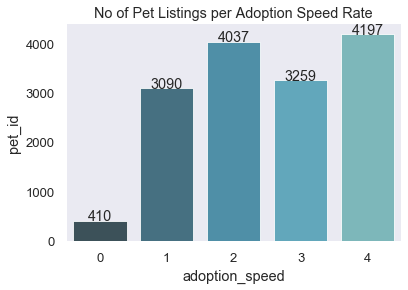

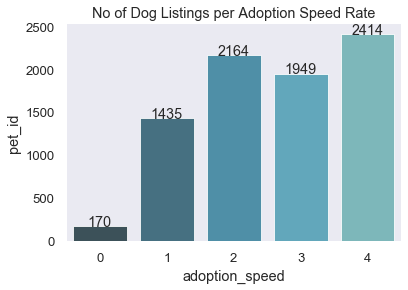

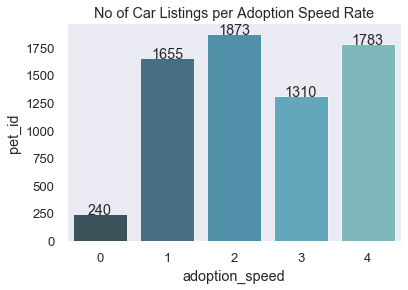

In [562]:
df_plot = pets.groupby("adoption_speed").count().reset_index()
eda.plot_bar(df_plot, "adoption_speed", "pet_id", "No of Pet Listings per Adoption Speed Rate")

df_plot = pets.query("type ==1").groupby("adoption_speed").count().reset_index()
eda.plot_bar(df_plot, "adoption_speed", "pet_id", "No of Dog Listings per Adoption Speed Rate")

df_plot = pets.query("type ==2").groupby("adoption_speed").count().reset_index()
eda.plot_bar(df_plot, "adoption_speed", "pet_id", "No of Car Listings per Adoption Speed Rate")

The amount of listings under class 0 is very low (3%) vs other classes. Class 0 means the pets were adopted the same day they were listed. Upon checking with Petfinder.my....

Based on this, I will move class 0 to 1.  Class 1 latter means the pets were adopted within the week of being listed.

### Age

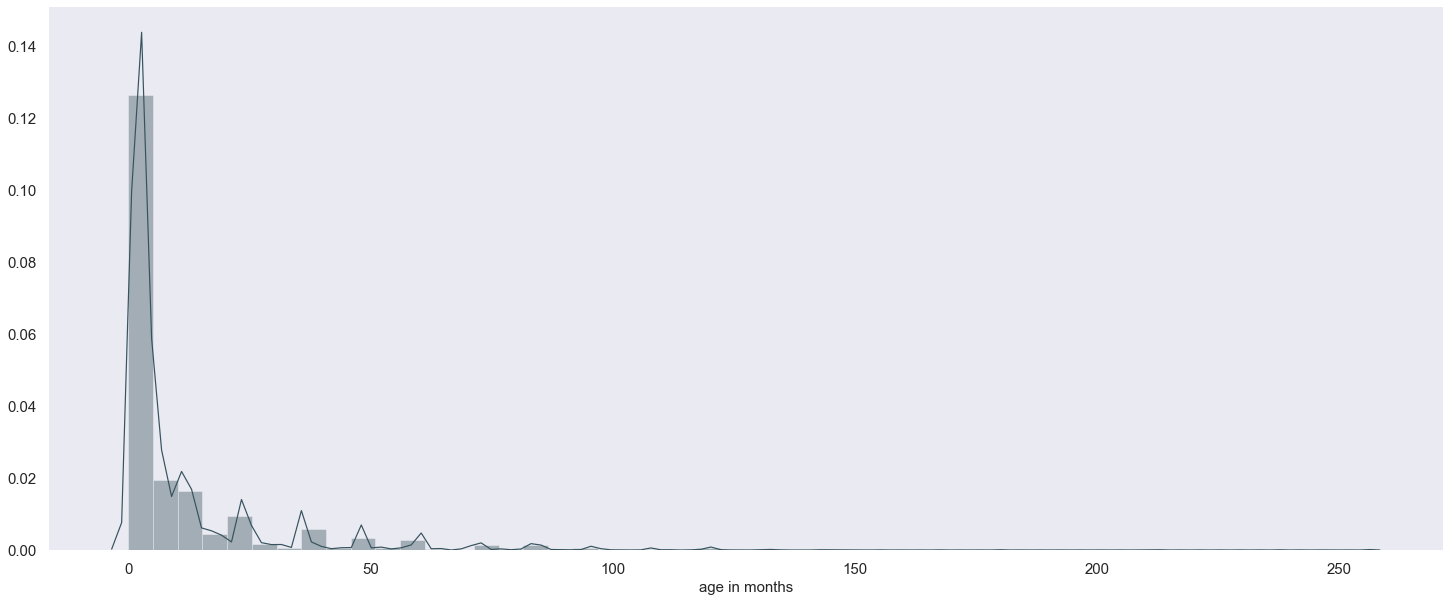

In [27]:
eda.plot_hist(pets["age"], "age in months", (25, 10))

In [28]:
round(pets.groupby("age").count().sort_values("pet_id", ascending = False)["pet_id"].head(10)/len(pets)*100,2)

age
2     23.36
1     15.37
3     13.11
4      7.40
12     6.45
24     4.34
5      3.97
6      3.72
36     2.78
8      2.06
Name: pet_id, dtype: float64

In [11]:
pets.query("age > 24").sort_values("age", ascending = False)[["pet_id", "age", "maturity_size"]].head(10)

pet_id  age  maturity_size
5160   5971c2462  255              2
11172  50682d0f1  255              2
13398  e01f077a7  238              2
11087  e77f9e778  212              1
3998   53923463d  212              2
12855  36d7fc2c5  212              2
8492   1d669183f  180              2
14637  bd006f963  180              2
9267   e5ffc0a9d  168              2
7512   739cd2d34  156              2

In [91]:
pets.query("age > 120")[["adoption_speed","pet_id", "age", "description"]].sort_values("age", ascending = False)

adoption_speed     pet_id  age  \
5160   4               5971c2462  255   
11172  4               50682d0f1  255   
13398  4               e01f077a7  238   
12855  4               36d7fc2c5  212   
11087  3               e77f9e778  212   
3998   3               53923463d  212   
8492   4               1d669183f  180   
14637  3               bd006f963  180   
9267   3               e5ffc0a9d  168   
7512   2               739cd2d34  156   
10501  1               7b8ea11de  147   
13493  4               b8715f663  144   
1363   3               077001793  144   
10128  4               e67f7787d  144   
11314  2               98c1efd96  144   
1867   3               70335663e  135   
2497   4               2a19120e7  132   
14303  1               1b9cedf4a  132   
1858   2               7f5e7cf4a  132   
513    3               f4f349714  132   
3931   3               bf497e792  132   
10426  4               c790696c7  132   
8065   3               a36e3c034  132   
6722   4               8fb06a963  132   
6666   4               1ef0bf320  123   
6569   4               290c3cd9e  122   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  description  
5160   very suitable to be a guard. easy handle. :) cute and fierce to strangers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
11172  very suitable to be a guard. easy handle. :) cute and fierce to strangers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [35]:
pets.query("age == 238")

adoption_speed     pet_id  type  name  age  breed1  breed1_desc  \
13398  4               e01f077a7  1     Enzo  238  307     mixed_breed   

       breed2 breed2_desc  gender  color1 color1_desc  color2 color2_desc  \
13398  0       NaN         1       7       white       0       NaN          

       color3 color3_desc  maturity_size  fur_length  vaccinated  dewormed  \
13398  0       NaN         2              1           1           1          

       sterilized  health  quantity  fee  state    state_desc  \
13398  1           1       1         0    41327  pulau_pinang   

                             rescuer_id  video_amt  photo_amt  \
13398  b39c5db7a450d0f3437ada1df3554db6  0          10.0        

                                                                                                                                                                description  
13398  Enzo was adopted from a pet store, and raised well. Mostly stayed indoors. Feed twice a day. Easy to bath. Clean & healthy. Know some tricks. Friendly and adorable.

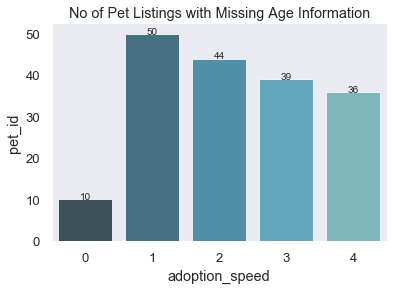

In [12]:
df_plot = pets.query("age == 0").groupby("adoption_speed").count().reset_index()
eda.plot_bar(df_plot, "adoption_speed", "pet_id", "No of Pet Listings with Missing Age Information")

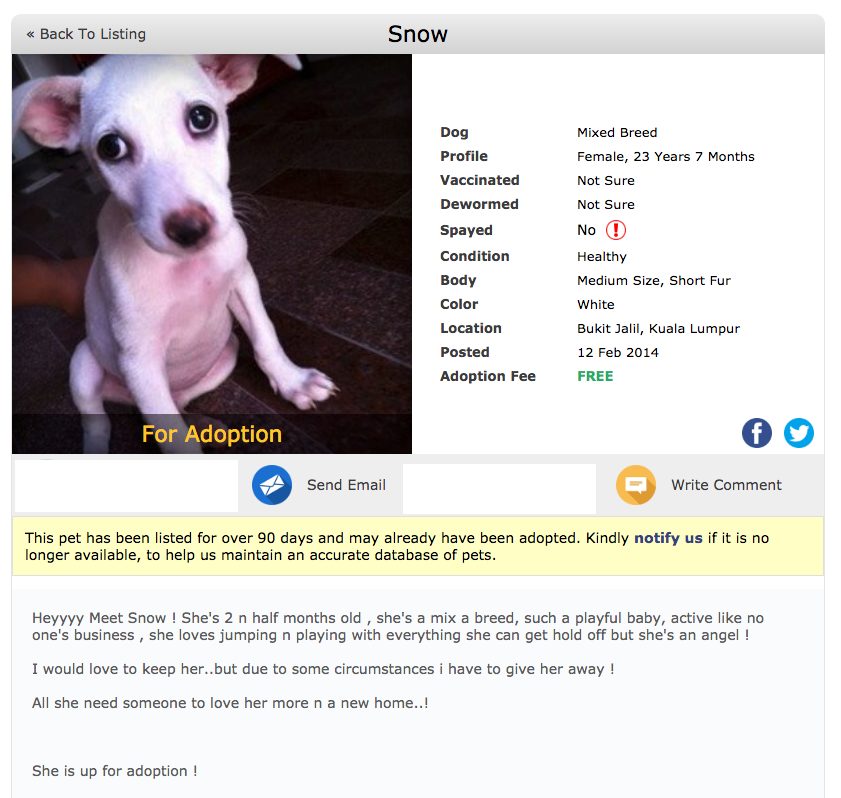

In [98]:
Image("dataset/snow.png")

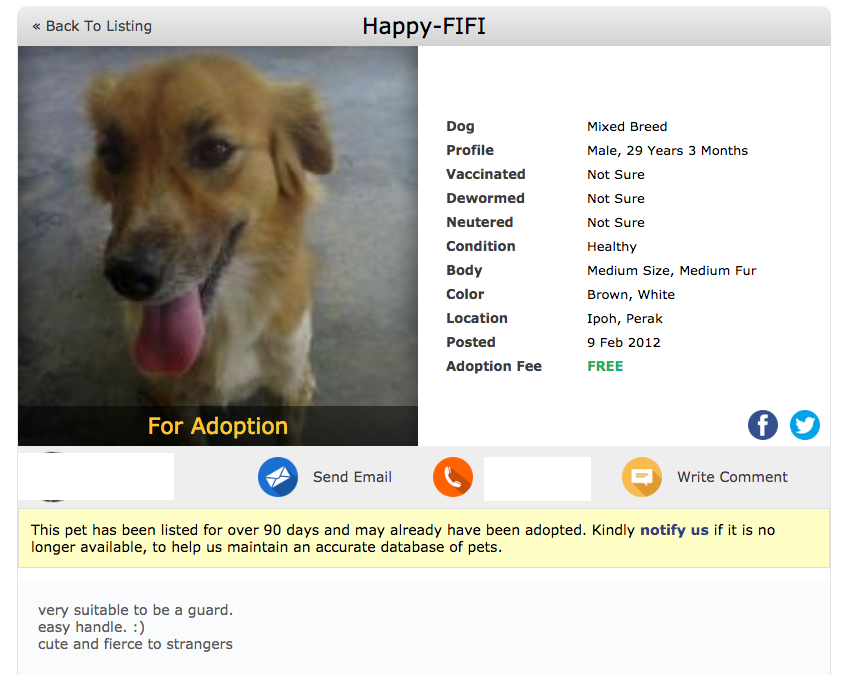

In [99]:
Image("dataset/fifi.png")

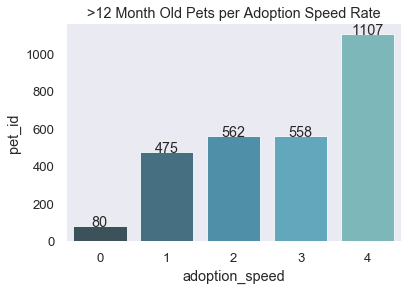

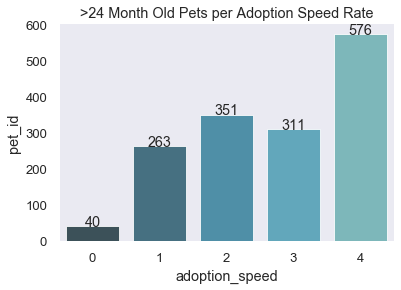

In [110]:
df_plot = pets.query("age > 12").groupby("adoption_speed").count().reset_index()
eda.plot_bar(df_plot, "adoption_speed", "pet_id", ">12 Month Old Pets per Adoption Speed Rate")
df_plot = pets.query("age > 24").groupby("adoption_speed").count().reset_index()
eda.plot_bar(df_plot, "adoption_speed", "pet_id", ">24 Month Old Pets per Adoption Speed Rate")

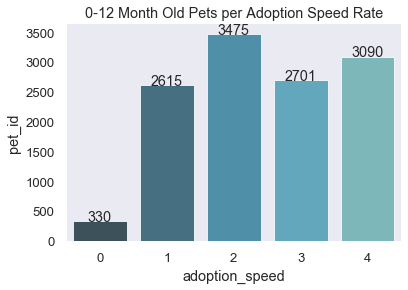

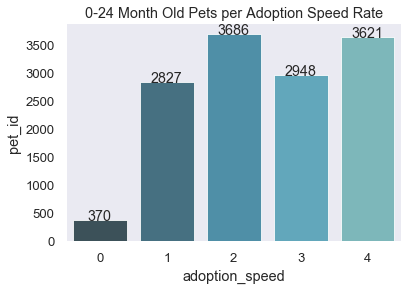

In [106]:
df_plot = pets.query("age <= 12").groupby("adoption_speed").count().reset_index()
eda.plot_bar(df_plot, "adoption_speed", "pet_id", "0-12 Month Old Pets per Adoption Speed Rate")
df_plot = pets.query("age <= 24").groupby("adoption_speed").count().reset_index()
eda.plot_bar(df_plot, "adoption_speed", "pet_id", "0-24 Month Old Pets per Adoption Speed Rate")

* There are 1541 (10%) pets that are more than 2 years old. Some of them are even more than 20 years old. 
* Seems that 12 and 24 months were used as placeholders. 
* Some of them have been listed for a while.  

I will convert the age into categorical feature: 0-2 years and more than 2 years old. In addition, age has a very low correlation with adoption speed.

I see no issue with age = 0 at adoption speed of 0-2 as this means the pets were adopted before they reached the age of 1 month.

Adoption speed rates at 3 & 4 mean that the pets were already been listed for more than a month.  I will be removing these listings as this is only 0.5% of the dataset.

### Breed

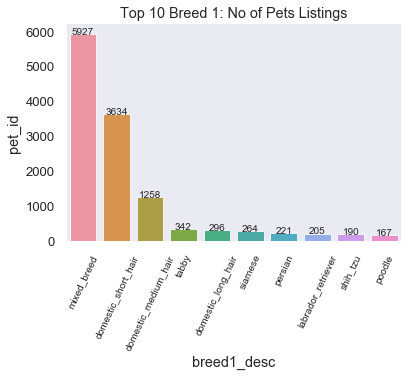

In [13]:
df_plot = pets[["breed1_desc",
                "pet_id"]].groupby("breed1_desc").count().sort_values(
                    "pet_id", ascending=False).iloc[:10, ].reset_index()
eda.plot_bar(df_plot, "breed1_desc", "pet_id",
             "Top 10 Breed 1: No of Pets Listings", rotate = True)

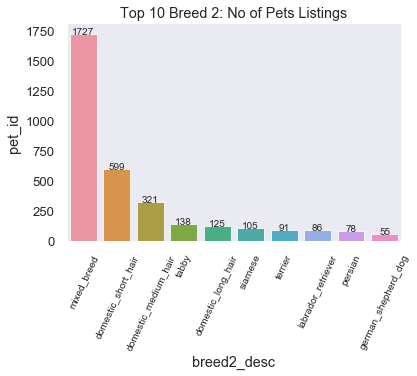

In [14]:
df_plot = pets[["breed2_desc",
                "pet_id"]].groupby("breed2_desc").count().sort_values(
                    "pet_id", ascending=False).iloc[:10, ].reset_index()
eda.plot_bar(df_plot, "breed2_desc", "pet_id",
             "Top 10 Breed 2: No of Pets Listings", rotate = True)

In [30]:
q = """SELECT breed1_desc, fur_length, count(breed1_desc) as listing_count FROM pets WHERE breed1_desc LIKE "%Domestic%" GROUP by breed1_desc, fur_length ORDER by listing_count DESC;"""
table = pysqldf(q)
table

breed1_desc  fur_length  listing_count
0   domestic_short_hair           1           3181
1  domestic_medium_hair           2           1162
2   domestic_short_hair           2            443
3    domestic_long_hair           3            201
4    domestic_long_hair           2             86
5  domestic_medium_hair           1             77
6  domestic_medium_hair           3             19
7   domestic_short_hair           3             10
8    domestic_long_hair           1              9

Mixed breed and domestic are the most common values. 

The domestic breed types are not consistent with the fur length.  Upon checking the website, the breed fields are drop downs while the fur lengths are radio buttons.  The fur length would be more accurately selected as compared to the specific type of "Domestic" breed. I will be changing all these to "Domestic" only and assume that the fur length is correct.

Also I will adding a column that will categorise the listings into Mixed Breed, Pure Breed, Domestic

### Gender

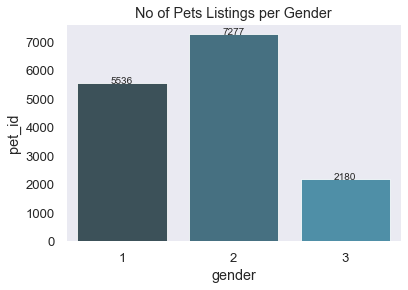

In [16]:
df_plot = pets[["gender","type", "adoption_speed", "pet_id"]].groupby(["gender","type", "adoption_speed"]).count().sort_values("pet_id", ascending=False).reset_index()

eda.plot_bar(df_plot.groupby("gender").sum().reset_index(), "gender", "pet_id",
             "No of Pets Listings per Gender", rotate = False)

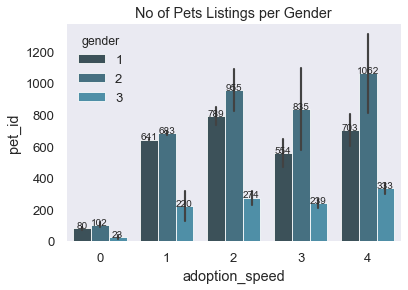

In [17]:
df_plot = pets[["gender","type", "adoption_speed", "pet_id"]].groupby(["gender","type", "adoption_speed"]).count().sort_values("pet_id", ascending=False).reset_index()

eda.plot_bar_hue(df_plot,"adoption_speed", "pet_id", "gender", "No of Pets Listings per Gender", rotate = False)

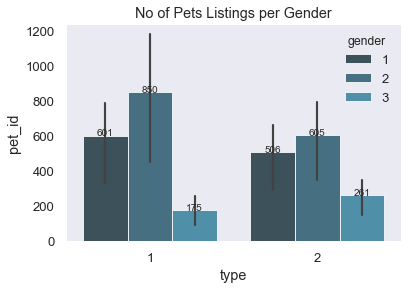

In [18]:
df_plot = pets[["gender","type", "adoption_speed", "pet_id"]].groupby(["gender", "adoption_speed", "type"]).count().sort_values("pet_id", ascending=False).reset_index()

eda.plot_bar_hue(df_plot,"type", "pet_id", "gender", "No of Pets Listings per Gender", rotate = False)

### Size at Maturity

In [664]:
pets.maturity_size.value_counts()

2    10305
1    3395 
3    1260 
4    33   
Name: maturity_size, dtype: int64

In [666]:
pets.query("maturity_size == 4")[["breed1_desc", "breed2_desc"]]

breed1_desc           breed2_desc
1265   great_dane                 NaN                 
1899   bullmastiff                rottweiler          
2461   saint_bernard              NaN                 
2514   domestic_short_hair        NaN                 
2523   rottweiler                 NaN                 
2738   rottweiler                 NaN                 
3157   golden_retriever           mixed_breed         
3558   doberman_pinscher          NaN                 
4706   great_dane                 NaN                 
5571   maine_coon                 bobtail             
5781   tabby                      NaN                 
6007   german_shepherd_dog        NaN                 
6712   tabby                      domestic_medium_hair
6899   mixed_breed                mixed_breed         
7692   doberman_pinscher          NaN                 
7854   german_shepherd_dog        NaN                 
8148   great_dane                 mixed_breed         
8184   domestic_short_hair        NaN                 
8316   rottweiler                 NaN                 
8381   belgian_shepherd_malinois  mixed_breed         
8457   norwegian_forest_cat       domestic_long_hair  
8754   german_shepherd_dog        NaN                 
9707   maine_coon                 NaN                 
10413  husky                      NaN                 
10737  german_shepherd_dog        NaN                 
11262  persian                    NaN                 
11338  rottweiler                 NaN                 
11745  belgian_shepherd_malinois  NaN                 
11854  mixed_breed                NaN                 
12366  siamese                    NaN                 
13618  tabby                      NaN                 
14005  saint_bernard              NaN                 
14043  russian_blue               NaN

In [669]:
pets.query("breed1_desc == 'great_dane'")[["breed1_desc", "breed2_desc", "maturity_size"]]

breed1_desc  breed2_desc  maturity_size
1265  great_dane  NaN          4            
3048  great_dane  NaN          3            
4540  great_dane  mixed_breed  3            
4706  great_dane  NaN          4            
8148  great_dane  mixed_breed  4            
8173  great_dane  NaN          3

In [673]:
pets.query("breed1_desc == 'bullmastiff'")[["breed1_desc", "breed2_desc", "maturity_size"]]

breed1_desc  breed2_desc  maturity_size
1899   bullmastiff  rottweiler   4            
2584   bullmastiff  mixed_breed  2            
5883   bullmastiff  mixed_breed  3            
6635   bullmastiff  NaN          3            
8207   bullmastiff  mixed_breed  2            
11330  bullmastiff  mixed_breed  2            
11587  bullmastiff  mixed_breed  2            
11832  bullmastiff  mixed_breed  2            
12539  bullmastiff  mixed_breed  2            
12641  bullmastiff  NaN          2            
12975  bullmastiff  mixed_breed  3            
13914  bullmastiff  boxer        3

### Description

In [90]:
dupe_desc = pets[pets.duplicated(["description", "quantity"], keep=False)]

dupe_desc[dupe_desc.description.isna() == False][[
    "pet_id", "age", "quantity", "description", "adoption_speed"]].sort_values("description").query("description ! = 'For Adoption'").query(
    "description ! = 'Dog 4 Adoption'").query(
        "description ! = 'Open for adoption!!!'").query("description ! = '-'")

pet_id  age  quantity  \
8409   1ccd49ce2  24   1          
4520   7ddf00d90  24   1          
2418   f68a56b90  24   1          
11577  d69a1f2a1  3    1          
8587   fd7ae9b79  3    1          
...          ... ..   ..          
5432   79799da25  10   1          
5672   c37d5c957  6    1          
7072   68c69f5c1  7    1          
1182   972fba985  9    1          
8212   bd485150e  6    1          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      description  \
8409   "This dog is one of the dogs rescued from the Klang Pound in April just before D-day (when they are put to death). It has been rehabilitated and urgently needs a loving home as we have limited resources. It is unfortunate that due to the aggressiveness of the contracted dogcatchers, most of these beautiful dogs are not strays and previously had homes. Hence, most of them are sociable and loving. Serving the voiceless, SAS Volunteer. P/s: Please contact Jackie by calling or texting her at, she's a grandma at emails. "   
4520   "This dog is one of the dogs rescued from the Klang Pound in April just before D-day (when they are put to death). It has been rehabilitated and urgently needs a loving home as we have limited resources. It is unfortunate that due to the aggressiveness of the contracted dogcatchers, most of these beautiful dogs are not strays and previously had homes. Hence, most of them are sociable and loving. Serving the voiceless, SAS Volunteer. P/s: Please contact Jackie by calling or texting her at, she's a grandma at emails. "   
2418   "This dog is one of the dogs rescued from the Klang Pound in April just before D-day (when they are put to death). It has been rehabilitated and urgently needs a loving home as we have limited resources. It is unfortunate that due to the aggressiveness of the contracted dogcatchers, most of these beautiful dogs are not strays and previously had homes. Hence, most of them are sociable and loving. Serving the voiceless, SAS Volunteer. P/s: Please contact Jackie by calling or texting her at, she's a grandma at emails. "   
11577  - 3 months old. - Female. - Blue eyed, white with black pattern. - Still shy with humans, but very playful with other kittens. We are now at Segambut, near Publika. Please let us know if you're interested to give her a permanent loving home.                                                                                                                                                                                                                                                                                            
8587   - 3 months old. - Female. - Blue eyed, white with black pattern. - Still shy with humans, but very playful with other kittens. We are now at Segambut, near Publika. Please let us know if you're interested to give her a permanent loving home.                                                                                                                                                                                                                                                                                            
...                                                                                                                                                                                                                                                  ...                                                                                                                                               

## Preparing the Data for Modelling

In [697]:
df = pd.read_csv("pets.csv")
pets = df.copy()
pets.shape

(14993, 30)

### Adjust the target variable

In [698]:
pets.adoption_speed.value_counts()

4    4197
2    4037
3    3259
1    3090
0    410 
Name: adoption_speed, dtype: int64

In [699]:
pets.adoption_speed = pets.adoption_speed.map(lambda x: 1 if x == 0 else x)
pets.adoption_speed.value_counts()

4    4197
2    4037
1    3500
3    3259
Name: adoption_speed, dtype: int64

### Features with Not Specified or Not Sure category

* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)

In [700]:
pets.maturity_size.value_counts()

2    10305
1    3395 
3    1260 
4    33   
Name: maturity_size, dtype: int64

In [701]:
no_info = pets.query("maturity_size == 4").index
pets = eda.drop_rows(pets, no_info)
pets.maturity_size.value_counts()

2    10305
1    3395 
3    1260 
Name: maturity_size, dtype: int64

In [702]:
pets.vaccinated.value_counts()

2    7225
1    5871
3    1864
Name: vaccinated, dtype: int64

In [703]:
pets.vaccinated = pets.vaccinated.map(lambda x: 2 if x == 3 else x)
pets.vaccinated.value_counts()

2    9089
1    5871
Name: vaccinated, dtype: int64

In [704]:
pets.dewormed.value_counts()

1    8371
2    4813
3    1776
Name: dewormed, dtype: int64

In [705]:
pets.dewormed = pets.dewormed.map(lambda x: 2 if x == 3 else x)
pets.dewormed.value_counts()

1    8371
2    6589
Name: dewormed, dtype: int64

In [706]:
pets.sterilized.value_counts()

2    10062
1    3086 
3    1812 
Name: sterilized, dtype: int64

In [707]:
pets.sterilized = pets.sterilized.map(lambda x: 2 if x == 3 else x)
pets.sterilized.value_counts()

2    11874
1    3086 
Name: sterilized, dtype: int64

### Duplicates, zero and null values

In [710]:
no_age = pets.query("age == 0").query("adoption_speed > 2").index
pets = eda.drop_rows(pets, no_age)

no_images = pets.query("photo_amt == 0").index
pets = eda.drop_rows(pets, no_images)

no_desc = pets[pets.description.isna() == True].index
pets = eda.drop_rows(pets, no_desc)

pets.reset_index(drop = True, inplace=True)

print("Original shape = ", df.shape)
print("New shape = ", pets.shape)

Original shape =  (14993, 30)
New shape =  (14543, 30)


In [711]:
#Check for NaN
pets.isna().sum()

adoption_speed    0    
pet_id            0    
type              0    
name              1181 
age               0    
breed1            0    
breed1_desc       4    
breed2            0    
breed2_desc       10440
gender            0    
color1            0    
color1_desc       0    
color2            0    
color2_desc       4308 
color3            0    
color3_desc       10306
maturity_size     0    
fur_length        0    
vaccinated        0    
dewormed          0    
sterilized        0    
health            0    
quantity          0    
fee               0    
state             0    
state_desc        0    
rescuer_id        0    
video_amt         0    
photo_amt         0    
description       0    
dtype: int64

### Add image filename to the dataframe

In [712]:
images_orig_path = "dataset/petfinder-adoption-prediction/train_images"
image_files = []

for r, d, f in os.walk(images_orig_path):  # r=root, d=directories, f = files
    for file in f:
        if ".jpg" in file:
            image_files.append(os.path.join(file))

image_files[:5]

['2d725d001-3.jpg',
 'bf9bd91e1-1.jpg',
 '9cb525274-3.jpg',
 '16ffedcf8-7.jpg',
 'a63364c39-1.jpg']

In [713]:
images = pd.DataFrame(data = image_files, columns = ["file_name"])
images["pet_id"] = images["file_name"].map(lambda x: str(x)[:9])
images = pd.merge(images, pets, on="pet_id", how="left")[["file_name", "pet_id"]]

print("There are ",len(images.drop_duplicates("pet_id")), " pets with images.")
print("There are a total of ",len(images), " pet images.")
images.head()

There are  14652  pets with images.
There are a total of  58311  pet images.


file_name     pet_id
0  2d725d001-3.jpg  2d725d001
1  bf9bd91e1-1.jpg  bf9bd91e1
2  9cb525274-3.jpg  9cb525274
3  16ffedcf8-7.jpg  16ffedcf8
4  a63364c39-1.jpg  a63364c39

In [714]:
unique_images = images.drop_duplicates("pet_id")
unique_images.shape

(14652, 2)

In [715]:
pets = pd.merge(pets, unique_images, on="pet_id", how="left")
pets.head(2)

adoption_speed     pet_id  type         name  age  breed1  \
0  2               86e1089a3  2     Nibble       3    299      
1  1               6296e909a  2     No Name Yet  1    265      

            breed1_desc  breed2 breed2_desc  gender  color1 color1_desc  \
0  tabby                 0       NaN         1       1       black        
1  domestic_medium_hair  0       NaN         1       1       black        

   color2 color2_desc  color3 color3_desc  maturity_size  fur_length  \
0  7       white       0       NaN         1              1            
1  2       brown       0       NaN         2              2            

   vaccinated  dewormed  sterilized  health  quantity  fee  state  \
0  2           2         2           1       1         100  41326   
1  2           2         2           1       1         0    41401   

     state_desc                        rescuer_id  video_amt  photo_amt  \
0  selangor      8480853f516546f6cf33aa88cd76c379  0          1.0         
1  kuala_lumpur  3082c7125d8fb66f7dd4bff4192c8b14  0          2.0         

                                                                                                                                                                                                                                                                                                                                                               description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.   
1  I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.                                                                                                                                                                                                                                                    

         file_name  
0  86e1089a3-1.jpg  
1  6296e909a-1.jpg

In [716]:
#Check for NaN
pets.isna().sum()

adoption_speed    0    
pet_id            0    
type              0    
name              1181 
age               0    
breed1            0    
breed1_desc       4    
breed2            0    
breed2_desc       10440
gender            0    
color1            0    
color1_desc       0    
color2            0    
color2_desc       4308 
color3            0    
color3_desc       10306
maturity_size     0    
fur_length        0    
vaccinated        0    
dewormed          0    
sterilized        0    
health            0    
quantity          0    
fee               0    
state             0    
state_desc        0    
rescuer_id        0    
video_amt         0    
photo_amt         0    
description       0    
file_name         0    
dtype: int64

In [717]:
# pets.to_csv("pets_with_image.csv", index=False)
# pets = pd.read_csv("pets_with_image.csv")
pets.shape

(14543, 31)

### Convert the categorical columns to dummy features

In [718]:
pets_dummies = pd.read_csv("pets_with_image.csv")
pets_dummies.shape

(14543, 31)

In [719]:
pets_dummies.type  = pets_dummies.type.map(lambda x: "dog" if x == 1 else "cat")
pets_dummies.type.value_counts()

dog    7883
cat    6660
Name: type, dtype: int64

In [720]:
#### Convert age into categorical
pets_dummies.age = pets_dummies.age.map(lambda x: "0-2y" if x <= 24 else ">2y")
pets_dummies.age.value_counts()

0-2y    13073
>2y     1470 
Name: age, dtype: int64

In [721]:
pets_dummies = eda.breed_dummies(pets_dummies)
print("New shape = ", pets_dummies.shape)

New shape =  (14543, 214)


In [722]:
pets_dummies = eda.color_dummies(pets_dummies)
print("New shape = ", pets_dummies.shape)

New shape =  (14543, 220)


In [723]:
pets_dummies = pd.get_dummies(pets_dummies, prefix = "state", columns = ["state_desc"], drop_first = True, dtype = "float64")
print("New shape = ", pets_dummies.shape)

New shape =  (14543, 232)


In [724]:
col_cat = ["type", "age", "maturity_size", "fur_length", "vaccinated", "dewormed", "sterilized", "health"]
pets_dummies = pd.get_dummies(pets_dummies, columns = col_cat, drop_first = True, dtype = "float64")
print("New shape = ", pets_dummies.shape)

New shape =  (14543, 235)


In [725]:
col_excl = [
    "name", "state", "rescuer_id", "breed1", "breed1_desc", "breed2",
    "breed2_desc", "gender", "color1", "color1_desc", "color2", "color2_desc",
    "color3", "color3_desc"
]
pets_dummies = eda.drop_columns(pets_dummies, col_excl)

print("New shape = ", pets_dummies.shape)
pets_dummies.head(2)

New shape =  (14543, 221)


adoption_speed     pet_id  quantity  fee  video_amt  photo_amt  \
0  2               86e1089a3  1         100  0          1.0         
1  1               6296e909a  1         0    0          2.0         

                                                                                                                                                                                                                                                                                                                                                               description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.   
1  I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.                                                                                                                                                                                                                                                    

         file_name  breed_abyssinian  breed_affenpinscher  \
0  86e1089a3-1.jpg  0.0               0.0                   
1  6296e909a-1.jpg  0.0               0.0                   

   breed_airedale_terrier  breed_akita  breed_american_bulldog  \
0  0.0                     0.0          0.0                      
1  0.0                     0.0          0.0                      

   breed_american_curl  breed_american_shorthair  \
0  0.0                  0.0                        
1  0.0                  0.0                        

   breed_american_staffordshire_terrier  breed_american_water_spaniel  \
0  0.0                                   0.0                            
1  0.0                                   0.0                            

   breed_american_wirehair  breed_applehead_siamese  breed_australian_kelpie  \
0  0.0                      0.0                      0.0                       
1  0.0                      0.0                      0.0                       

   breed_australian_shepherd  breed_australian_terrier  breed_balinese  \
0  0.0                        0.0                       0.0              
1  0.0                        0.0                       0.0              

   breed_basenji  breed_basset_hound  breed_beagle  breed_bearded_collie  \
0  0.0            0.0                 0.0           0.0                    
1  0.0            0.0                 0.0           0.0                    

   breed_bedlington_terrier  breed_belgian_shepherd_dog_sheepdog  \
0  0.0                       0.0                                   
1  0.0                       0.0                                   

   breed_belgian_shepherd_laekenois  breed_belgian_shepherd_malinois  \
0  0.0                               0.0                               
1  0.0                               0.0                               

   breed_bengal  breed_birman  breed_black_labrador_retriever  \
0  0.0           0.0           0.0                              
1  0.0           0.0           0.0                              

   breed_black_mouth_cur  breed_bobtail  breed_bombay  breed_border_collie  \
0  0.0                    0.0            0.0           0.0                   
1  0.0                    0.0            0.0           0.0                   

   breed_boston_terrier  breed_boxer  breed_british_shorthair  \
0  0.0                   0.0          0.0                       
1  0.0                   0.0          0.0                       

   breed_bull_terrier  breed_bullmastiff  breed_burmese  breed_burmilla  \
0  0.0                 0.0                0.0            0.0              
1  0.0                 0.0                0.

In [726]:
pets_dummies.isna().sum().sum()

0

In [727]:
list(pets_dummies.columns)

['adoption_speed',
 'pet_id',
 'quantity',
 'fee',
 'video_amt',
 'photo_amt',
 'description',
 'file_name',
 'breed_abyssinian',
 'breed_affenpinscher',
 'breed_airedale_terrier',
 'breed_akita',
 'breed_american_bulldog',
 'breed_american_curl',
 'breed_american_shorthair',
 'breed_american_staffordshire_terrier',
 'breed_american_water_spaniel',
 'breed_american_wirehair',
 'breed_applehead_siamese',
 'breed_australian_kelpie',
 'breed_australian_shepherd',
 'breed_australian_terrier',
 'breed_balinese',
 'breed_basenji',
 'breed_basset_hound',
 'breed_beagle',
 'breed_bearded_collie',
 'breed_bedlington_terrier',
 'breed_belgian_shepherd_dog_sheepdog',
 'breed_belgian_shepherd_laekenois',
 'breed_belgian_shepherd_malinois',
 'breed_bengal',
 'breed_birman',
 'breed_black_labrador_retriever',
 'breed_black_mouth_cur',
 'breed_bobtail',
 'breed_bombay',
 'breed_border_collie',
 'breed_boston_terrier',
 'breed_boxer',
 'breed_british_shorthair',
 'breed_bull_terrier',
 'breed_bullmast

In [728]:
pets_dummies.to_csv("pets_modelA.csv", index=False)

### Bin Breeds for Random Forest

As there are 307 possible values for breeds and they do not have a natural ordering, I will bin and order the breeds based on how fast they are adopted.

Since Mixed Breed and Domestic are the most common values, I will categorised breed into these 3:
1. Pure Bred Non-Domestic
2. Pure Bred Domestic 
3. Mixed Bred

State and color columns do not have a natural ordering as well.  As the possible values are only 15 and 7, respectively, I will instead convert these into dummy variables.

In [729]:
pets_bins = pd.read_csv("pets_with_image.csv")
display(pets_bins.shape)
pets_bins.head(2)

(14543, 31)

adoption_speed     pet_id  type         name  age  breed1  \
0  2               86e1089a3  2     Nibble       3    299      
1  1               6296e909a  2     No Name Yet  1    265      

            breed1_desc  breed2 breed2_desc  gender  color1 color1_desc  \
0  tabby                 0       NaN         1       1       black        
1  domestic_medium_hair  0       NaN         1       1       black        

   color2 color2_desc  color3 color3_desc  maturity_size  fur_length  \
0  7       white       0       NaN         1              1            
1  2       brown       0       NaN         2              2            

   vaccinated  dewormed  sterilized  health  quantity  fee  state  \
0  2           2         2           1       1         100  41326   
1  2           2         2           1       1         0    41401   

     state_desc                        rescuer_id  video_amt  photo_amt  \
0  selangor      8480853f516546f6cf33aa88cd76c379  0          1.0         
1  kuala_lumpur  3082c7125d8fb66f7dd4bff4192c8b14  0          2.0         

                                                                                                                                                                                                                                                                                                                                                               description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.   
1  I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.                                                                                                                                                                                                                                                    

         file_name  
0  86e1089a3-1.jpg  
1  6296e909a-1.jpg

In [730]:
pets_bins = eda.bin_breed(pets_bins)
print("New shape: ", pets_bins.shape)

New shape:  (14543, 33)


In [731]:
pets_bins[["breed_bin", "breed1_desc", "breed2_desc"]].sample(10)

breed_bin           breed1_desc           breed2_desc
14018  3.0        persian               ragdoll             
3938   3.0        mixed_breed           NaN                 
3297   3.0        mixed_breed           NaN                 
1573   1.0        calico                NaN                 
2395   1.0        calico                calico              
5321   3.0        mixed_breed           german_shepherd_dog 
4210   2.0        domestic_short_hair   NaN                 
2548   2.0        domestic_short_hair   NaN                 
594    2.0        domestic_short_hair   domestic_medium_hair
134    2.0        domestic_medium_hair  NaN

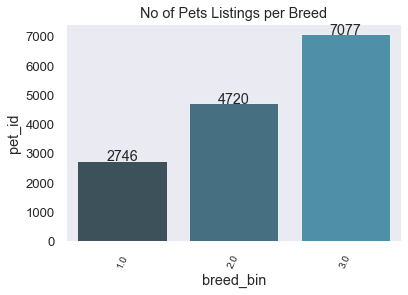

In [732]:
df_plot = pets_bins[["breed_bin",
                "pet_id"]].groupby("breed_bin").count().sort_values(
                    "pet_id", ascending=False).iloc[:10, ].reset_index()
eda.plot_bar(df_plot, "breed_bin", "pet_id",
             "No of Pets Listings per Breed", rotate = True)

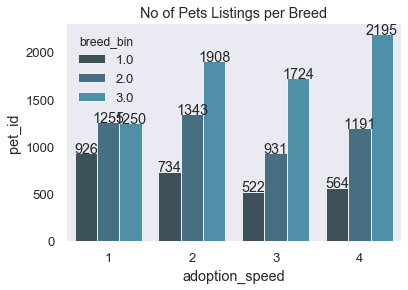

In [733]:
df_plot = pets_bins[["breed_bin", "adoption_speed", "pet_id"]].groupby(["breed_bin", "adoption_speed"]).count().sort_values("pet_id", ascending=False).reset_index()
eda.plot_bar_hue(df_plot,"adoption_speed", "pet_id", "breed_bin", "No of Pets Listings per Breed", rotate = False)

In [734]:
check = pd.merge(pets_bins[["breed_bin", "adoption_speed", "pet_id"]].groupby([
    "breed_bin", "adoption_speed"
]).count().sort_values(["breed_bin", "adoption_speed"]).reset_index(),
                 pets_bins[["breed_bin", "pet_id"
                            ]].groupby(["breed_bin"]).count().reset_index(),
                 on="breed_bin")
check["ratio"] = check["pet_id_x"] / check["pet_id_y"]

print("AdoptionSpeed 0-2")
display(check[["breed_bin", "adoption_speed", "ratio"
               ]].query("adoption_speed < 3").groupby("breed_bin").sum()[[
                   "ratio"
               ]].sort_values("ratio", ascending=False))
print("Adoption Speed 3&4")
display(check[["breed_bin", "adoption_speed", "ratio"
               ]].query("adoption_speed > 2").groupby("breed_bin").sum()[[
                   "ratio"
               ]].sort_values("ratio"))

AdoptionSpeed 0-2


ratio
breed_bin          
1.0        0.604516
2.0        0.550424
3.0        0.446234

Adoption Speed 3&4


ratio
breed_bin          
1.0        0.395484
2.0        0.449576
3.0        0.553766

In [739]:
pets_bins.breed_bin = pets_bins.breed_bin.astype("int64")
pets_bins.breed_bin.value_counts()

3    7077
2    4720
1    2746
Name: breed_bin, dtype: int64

Based on the above tables, breed 1 has the highest percentage of listings adopted within a month and also has the lowest for more than a month.  Moreover, the orders for both tables are the same hence the binning method works.

In [735]:
pets_bins.type  = pets_bins.type.map(lambda x: "dog" if x == 1 else "cat")
pets_bins.type.value_counts()

dog    7883
cat    6660
Name: type, dtype: int64

In [736]:
#### Convert age into categorical
pets_bins.age = pets_bins.age.map(lambda x: 0 if x <= 24 else 1)
pets_bins.age.value_counts()

0    13073
1    1470 
Name: age, dtype: int64

In [737]:
pets_bins = eda.color_dummies(pets_bins)
print("New shape = ", pets_bins.shape)

New shape =  (14543, 39)


In [738]:
pets_bins = pd.get_dummies(pets_bins, prefix="state", columns = ["state_desc"], drop_first = True, dtype = "float64")
print("New shape = ", pets_bins.shape)

New shape =  (14543, 51)


In [740]:
col_cat = ["type", "breed_bin", "vaccinated", "dewormed", "sterilized"]
pets_bins = pd.get_dummies(pets_bins, columns = col_cat, drop_first = True, dtype = "float64")
print("New shape = ",  pets_bins.shape)

New shape =  (14543, 52)


In [742]:
col_excl = [
    "name", "state", "rescuer_id", "breed1", "breed1_desc", "breed2",
    "breed2_desc", "gender", "color1", "color1_desc", "color2", "color2_desc",
    "color3", "color3_desc", "check"
]
pets_bins = eda.drop_columns(pets_bins, col_excl)

print("New shape = ", pets_bins.shape)
pets_bins.head(2)

New shape =  (14543, 37)


adoption_speed     pet_id  age  maturity_size  fur_length  health  \
0  2               86e1089a3  0    1              1           1        
1  1               6296e909a  0    2              2           1        

   quantity  fee  video_amt  photo_amt  \
0  1         100  0          1.0         
1  1         0    0          2.0         

                                                                                                                                                                                                                                                                                                                                                               description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.   
1  I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.                                                                                                                                                                                                                                                    

         file_name  color_brown  color_cream  color_golden  color_gray  \
0  86e1089a3-1.jpg  0.0          0.0          0.0           0.0          
1  6296e909a-1.jpg  1.0          0.0          0.0           0.0          

   color_white  color_yellow  state_kedah  state_kelantan  state_kuala_lumpur  \
0  1.0          0.0           0.0          0.0             0.0                  
1  0.0          0.0           0.0          0.0             1.0                  

   state_labuan  state_melaka  state_negeri_sembilan  state_pahang  \
0  0.0           0.0           0.0                    0.0            
1  0.0           0.0           0.0                    0.0            

   state_perak  state_pulau_pinang  state_sabah  state_sarawak  \
0  0.0          0.0                 0.0          0.0             
1  0.0          0.0                 0.0          0.0             

   state_selangor  state_terengganu  type_dog  breed_bin_2  breed_bin_3  \
0  1.0             0.0               0.0       0.0          0.0           
1  0.0             0.0               0.0       1.0          0.0           

   vaccinated_2  dewormed_2  sterilized_2  
0  1.0           1.0         1.0           
1  1.0           1.0         1.0

In [743]:
pets_bins.isna().sum().sum()

0

In [744]:
list(pets_bins.columns)

['adoption_speed',
 'pet_id',
 'age',
 'maturity_size',
 'fur_length',
 'health',
 'quantity',
 'fee',
 'video_amt',
 'photo_amt',
 'description',
 'file_name',
 'color_brown',
 'color_cream',
 'color_golden',
 'color_gray',
 'color_white',
 'color_yellow',
 'state_kedah',
 'state_kelantan',
 'state_kuala_lumpur',
 'state_labuan',
 'state_melaka',
 'state_negeri_sembilan',
 'state_pahang',
 'state_perak',
 'state_pulau_pinang',
 'state_sabah',
 'state_sarawak',
 'state_selangor',
 'state_terengganu',
 'type_dog',
 'breed_bin_2',
 'breed_bin_3',
 'vaccinated_2',
 'dewormed_2',
 'sterilized_2']

In [745]:
pets_bins.to_csv("pets_modelB.csv", index=False)

# Multi-class Problem

In [849]:
pets = pd.read_csv("pets_modelB.csv")
pets = eda.drop_columns(pets, ["pet_id","description","file_name"])
display(pets.shape)
pets.head()

(14543, 34)

adoption_speed  age  maturity_size  fur_length  health  quantity  fee  \
0  2               0    1              1           1       1         100   
1  1               0    2              2           1       1         0     
2  3               0    2              2           1       1         0     
3  2               0    2              1           1       1         150   
4  2               0    2              1           1       1         0     

   video_amt  photo_amt  color_brown  color_cream  color_golden  color_gray  \
0  0          1.0        0.0          0.0          0.0           0.0          
1  0          2.0        1.0          0.0          0.0           0.0          
2  0          7.0        1.0          0.0          0.0           0.0          
3  0          8.0        1.0          0.0          0.0           0.0          
4  0          3.0        0.0          0.0          0.0           0.0          

   color_white  color_yellow  state_kedah  state_kelantan  state_kuala_lumpur  \
0  1.0          0.0           0.0          0.0             0.0                  
1  0.0          0.0           0.0          0.0             1.0                  
2  1.0          0.0           0.0          0.0             0.0                  
3  0.0          0.0           0.0          0.0             1.0                  
4  0.0          0.0           0.0          0.0             0.0                  

   state_labuan  state_melaka  state_negeri_sembilan  state_pahang  \
0  0.0           0.0           0.0                    0.0            
1  0.0           0.0           0.0                    0.0            
2  0.0           0.0           0.0                    0.0            
3  0.0           0.0           0.0                    0.0            
4  0.0           0.0           0.0                    0.0            

   state_perak  state_pulau_pinang  state_sabah  state_sarawak  \
0  0.0          0.0                 0.0          0.0             
1  0.0          0.0                 0.0          0.0             
2  0.0          0.0                 0.0          0.0             
3  0.0          0.0                 0.0          0.0             
4  0.0          0.0                 0.0          0.0             

   state_selangor  state_terengganu  type_dog  breed_bin_2  breed_bin_3  \
0  1.0             0.0               0.0       0.0          0.0           
1  0.0             0.0               0.0       1.0          0.0           
2  1.0             0.0               1.0       0.0          1.0           
3  0.0             0.0               1.0       0.0          1.0           
4  1.0             0.0               1.0       0.0          1.0           

   vaccinated_2  dewormed_2  sterilized_2  
0  1.0           1.0         1.0           
1  1.0           1.0         1.0           
2  0.0           0.0         1.0           
3  0.0           0.0         1.0           
4  1.0           1.0         1.0

In [850]:
pets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14543 entries, 0 to 14542
Data columns (total 34 columns):
adoption_speed           14543 non-null int64
age                      14543 non-null int64
maturity_size            14543 non-null int64
fur_length               14543 non-null int64
health                   14543 non-null int64
quantity                 14543 non-null int64
fee                      14543 non-null int64
video_amt                14543 non-null int64
photo_amt                14543 non-null float64
color_brown              14543 non-null float64
color_cream              14543 non-null float64
color_golden             14543 non-null float64
color_gray               14543 non-null float64
color_white              14543 non-null float64
color_yellow             14543 non-null float64
state_kedah              14543 non-null float64
state_kelantan           14543 non-null float64
state_kuala_lumpur       14543 non-null float64
state_labuan             14543 non-null flo

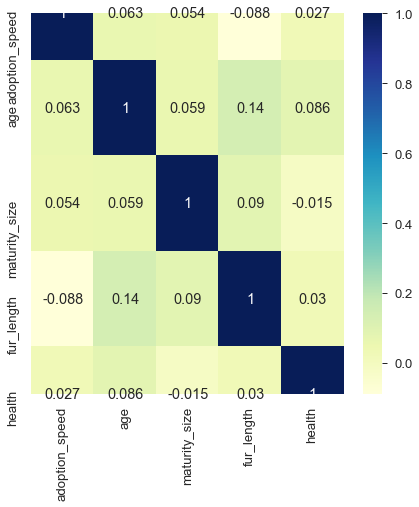

In [851]:
plt.figure(figsize=(7, 7))
sns.heatmap(data = pets.iloc[:,0:5].corr(), annot=True, cmap="YlGnBu");

In [852]:
pets.columns

Index(['adoption_speed', 'age', 'maturity_size', 'fur_length', 'health',
       'quantity', 'fee', 'video_amt', 'photo_amt', 'color_brown',
       'color_cream', 'color_golden', 'color_gray', 'color_white',
       'color_yellow', 'state_kedah', 'state_kelantan', 'state_kuala_lumpur',
       'state_labuan', 'state_melaka', 'state_negeri_sembilan', 'state_pahang',
       'state_perak', 'state_pulau_pinang', 'state_sabah', 'state_sarawak',
       'state_selangor', 'state_terengganu', 'type_dog', 'breed_bin_2',
       'breed_bin_3', 'vaccinated_2', 'dewormed_2', 'sterilized_2'],
      dtype='object')

In [853]:
y = pets[["adoption_speed"]]
X = eda.drop_columns(pets, ["adoption_speed"])
cols_to_scale = ["video_amt", "photo_amt", "fee"]

In [854]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

In [855]:
X_train_scaled, X_test_scaled = func.minmax_scaler(X_train, X_test, cols_to_scale)

In [856]:
logreg = LogisticRegression(class_weight="balanced",
                            multi_class="ovr")#,
                            #solver="lbfgs")
    
crossvalidation = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
baseline = np.mean(cross_val_score(logreg, X_train_scaled, y_train, scoring="accuracy", cv=crossvalidation))
baseline

0.35087621183120193

In [857]:
logreg.fit(X_train_scaled, y_train)

y_train_pred= logreg.predict(X_train_scaled)
y_test_pred = logreg.predict(X_test_scaled)
probas = logreg.predict_proba(X_test_scaled)

print(classification_report(y_test, y_test_pred))
print(cohen_kappa_score(y_test, y_test_pred, weights="quadratic"))

              precision    recall  f1-score   support

           1       0.34      0.49      0.40       831
           2       0.32      0.18      0.24       985
           3       0.33      0.25      0.29       833
           4       0.41      0.52      0.46       987

    accuracy                           0.36      3636
   macro avg       0.35      0.36      0.35      3636
weighted avg       0.35      0.36      0.35      3636

0.22613569226175467


In [858]:
logreg = LogisticRegression(class_weight="balanced",
                            multi_class="ovr")#,
                            #solver="lbfgs")
    
crossvalidation = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)
baseline = np.mean(cross_val_score(logreg, X_train_scaled, y_train, scoring="accuracy", cv=crossvalidation))
baseline

0.35087621183120193

In [845]:
def score_clf(X_train, X_test, y_train, y_test, estimator, **kwargs):
    """
    Test various estimators.
    """
    
    model = Pipeline([('estimator', estimator)])


    model.fit(X_train, y_train)

    y_test_pred = model.predict(X_test_scaled)

    print("{} accuracy: {}".format(estimator.__class__.__name__,
                                   accuracy_score(y_test, y_test_pred)))
    print("{} quadratic cohen kappa score: {}".format(
        estimator.__class__.__name__,
        cohen_kappa_score(y_test, y_test_pred, weights="quadratic")))

In [838]:
classifiers = [
    LogisticRegressionCV(class_weight="balanced"),
    KNeighborsClassifier(n_neighbors=5),
    GaussianProcessClassifier(multi_class="one_vs_rest"),
    SGDClassifier(class_weight="balanced"),
    DecisionTreeClassifier(max_depth=10, class_weight="balanced"),
    RandomForestClassifier(max_depth=10, class_weight="balanced"),
    ExtraTreesClassifier(max_depth=10, class_weight="balanced"),
    BaggingClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

In [ ]:
for clf in classifiers:
    score_clf(X_train_scaled, X_test_scaled, y_train, y_test, clf)

LogisticRegressionCV accuracy: 0.33910891089108913
LogisticRegressionCV quadratic cohen kappa score: 0.21081092242976962
KNeighborsClassifier accuracy: 0.3184818481848185
KNeighborsClassifier quadratic cohen kappa score: 0.1460752883214932


# Image Classification

In [ ]:
# images_orig_path = "dataset/petfinder-adoption-prediction/train_images"
# image_files = []

# for r, d, f in os.walk(images_orig_path):  # r=root, d=directories, f = files
#     for file in f:
#         if ".jpg" in file:
#             image_files.append(os.path.join(file))

image_files[:5]

In [ ]:
# images = pd.DataFrame(data = image_files, columns = ["file_name"])
# images["pet_id"] = images["file_name"].map(lambda x: str(x)[:9])
# images = pd.merge(images, pets, on="pet_id", how="left")[["file_name", "pet_id", "type"]]

# print("There are ",len(images.drop_duplicates("pet_id")), " pets with images.")
# print("There are a total of ",len(images), " pet images.")
# images.head()

In [ ]:
# images_dog = list(images.query("type == 1").file_name)
# images_cat = list(images.query("type == 2").file_name)

# dog_folder = "dataset/images/dog/"
# cat_folder = "dataset/images/cat/"

# im.copy_images(images_dog, images_orig_path, dog_folder)
# im.copy_images(images_cat, images_orig_path, cat_folder)

In [ ]:
# images_dog = list(images.drop_duplicates("pet_id").query("type == 1").file_name)
# images_cat = list(images.drop_duplicates("pet_id").query("type == 2").file_name)

# dog_folder = "dataset/images_unique/dog/"
# cat_folder = "dataset/images_unique/cat/"

# im.copy_images(images_dog, images_orig_path, dog_folder)
# im.copy_images(images_cat, images_orig_path, cat_folder)

# Text Classification

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
# pets_desc = pets[["pet_id","adoption_speed", "description"]]
# pets_desc

In [ ]:
# stopwords_list = stopwords.words("english") + list(string.punctuation)